# Centralized Learning

In [1]:
from collections import OrderedDict
from functools import reduce
from logging import WARNING
from typing import List, Tuple, Optional, Dict
import time
import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from flwr.common import Metrics
from flwr.common.logger import log
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import CIFAR10

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

Training on cpu using PyTorch 1.13.1+cpu and Flower 1.1.0


In [2]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
NUM_CLIENTS = 5

In [3]:

BATCH_SIZE = 32


def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=False, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=False, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    print(f"Partition Size {partition_size}")
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

Partition Size 10000


In [ ]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis('off')

# Show the plot
fig.tight_layout()
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    training_start_time = time.time()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(
                f"Epoch {epoch + 1}: train loss:  {epoch_loss}, accuracy: {epoch_acc}, time taken: {time.time() - training_start_time}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [6]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

train(net, trainloader, 5, True)

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: train loss:  0.0609118714928627, accuracy: 0.2857777777777778, time taken: 7.129122257232666
Epoch 2: train loss:  0.051145777106285095, accuracy: 0.4036666666666667, time taken: 14.52414083480835
Epoch 3: train loss:  0.047633178532123566, accuracy: 0.45266666666666666, time taken: 20.011831760406494
Epoch 4: train loss:  0.04540535807609558, accuracy: 0.47355555555555556, time taken: 26.226503610610962
Epoch 5: train loss:  0.043145958334207535, accuracy: 0.5047777777777778, time taken: 32.376086950302124
Final test set performance:
	loss 0.046109443014860155
	accuracy 0.4722


In [7]:
print(net.parameters)

<bound method Module.parameters of Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>


In [14]:
net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 1.2593e-01,  3.8336e-03,  1.0969e-01,  1.0288e-01,  1.2610e-01],
                        [ 1.4847e-01,  4.0549e-02,  1.1118e-01,  1.5901e-01,  1.4221e-01],
                        [ 1.0433e-01, -3.0654e-02,  3.6898e-02,  1.2818e-01, -8.5203e-03],
                        [ 1.9430e-03,  9.4767e-02, -2.6406e-02,  1.3003e-02, -3.8722e-02],
                        [ 7.4890e-02,  1.4252e-02,  9.9529e-02, -6.5343e-02,  2.4168e-02]],
              
                       [[-8.6983e-02, -6.1519e-02, -9.5589e-02, -1.0674e-01, -7.5533e-02],
                        [-1.3883e-01, -2.9105e-02, -1.6589e-01,  1.5227e-02,  4.6386e-02],
                        [ 2.5141e-02, -1.3531e-01, -9.8526e-02, -1.8693e-01, -5.8887e-02],
                        [-7.1786e-02, -1.4223e-01, -1.1989e-01, -1.6119e-01,  4.6976e-02],
                        [-3.3080e-03, -9.1927e-02, -3.4500e-02, -1.0278e-01,  1.0840e-01]],
              
                       [[-4.

In [13]:
parameters = [val.cpu().numpy() for _, val in net.state_dict().items()]
len(parameters)

10

In [9]:
net.state_dict()['fc3.weight']

tensor([[-8.2469e-02,  1.0380e-01,  6.6041e-02,  4.5528e-02,  1.5623e-01,
         -3.8720e-02,  1.8360e-03, -6.8944e-02, -8.0996e-02, -1.5849e-02,
         -7.4694e-02, -8.9709e-02,  9.7648e-02, -6.1623e-02, -1.0578e-01,
         -6.4200e-02, -9.6507e-03,  8.4469e-02,  1.3175e-01,  1.5983e-01,
          1.1330e-01, -1.5863e-01, -1.8022e-02,  7.9670e-02,  1.0149e-01,
          8.2843e-02, -4.0892e-02,  5.9308e-03, -1.4556e-01, -9.3157e-03,
         -1.3327e-01, -7.9622e-03, -1.2148e-01, -4.7770e-02, -2.0023e-02,
         -2.6655e-02, -4.8056e-02,  1.1786e-01, -3.2723e-02, -1.2986e-01,
         -1.0184e-02, -6.2381e-02,  9.8214e-02,  3.4254e-02, -3.5590e-02,
         -1.0495e-01,  2.6654e-02,  2.3903e-02, -5.3144e-02, -8.4824e-02,
         -7.0092e-02, -8.2870e-02, -7.1288e-02,  1.0043e-01, -1.4809e-02,
         -1.2269e-01,  5.0898e-02, -2.7730e-02, -1.8411e-02,  3.1218e-02,
         -9.6880e-02, -3.8021e-02,  3.1538e-02, -1.1906e-03,  9.4977e-02,
         -1.1341e-01,  1.2363e-01,  5.

In [23]:
numpy_weights = net.state_dict()['fc3.weight'].cpu().detach().numpy()
print(numpy_weights.shape)

(10, 84)


In [24]:
print(numpy_weights[:3].shape)

(3, 84)


In [25]:
from flwr.common import ndarray_to_bytes

tensors = [ndarray_to_bytes(ndarray) for ndarray in net.state_dict()['fc3.weight']]
tensors

[b"\x93NUMPY\x01\x00v\x00{'descr': '<f4', 'fortran_order': False, 'shape': (84,), }                                                           \n\x8f\x92\x99\xbd'\xef\xb6\xbd1\x0b_\xbcV\xc6\xc1\xbd\x19\x94\xd9=(\xb2\x83\xbc\xe7\x01\xc1\xbd\xc8Y\xe1=\xf3Ja\xbd\x1cK\xc0=\x1f\xf2\x87=\x83\xc1\xcc=\x02\x0f\xe3\xbd\xc5\xbf(=h\xe9\xcc\xbd\xf1\xd6\xa1=\x18/e\xbd\x08m\xa6\xbb\xaa\x08\xac;`\xc2+\xbdPt\x06<$\xf7E=\x060i\xbd\x1c6\xe6=\x1c\x1c=={3\xe7\xbd\x0c3\x85;\x82~\xdd=\\\xae\x07>\x01z\xb8<\x87%\x80\xbd\xfd\xa5 \xbc`\xce\xbb\xbd\xae\xce\x80<\xf5y\xec\xbck\xfd\xf1<\x98\x14\x05\xbeP,\xcd\xbd\xdbq\xe9\xbd4d\x1a\xbc\xc12\xbc=\xb0\xdd\x01\xbd@\xaeR\xbd\xbd\xf1!=\xa8\xc0\x80\xbc\x90\xc5\xc2\xbd\xc5Z\xde<\xd4Gm=\xa0\x03\x00\xbd\x13\x88\xac\xbc40i\xbd\xc0\x1b\x10=\x90O\x06\xbe\xf0\xcb\x08<\xdfa\xb4\xbd\x14\xf5F=-V\x90\xbd\xbf\xc4\x1b\xbe>\xc7\xae=\xc9\x11k\xbc\xb6P_=b\xff~\xbd\xa8[M=\x831o;\xc6\xa8\xec=\xcek7\xbd\xe6A\xa1=;@\xc5\xbd\xc78F\xbd\xfb\x9f\xf8<\xd0W\xa0=18\xfa<\t\xb5\xd3<|%V=\x86\xbbD=\x9d]

# Federated Learning

In [26]:
def get_parameters(net) -> List[np.ndarray]:
    # temp_1 = val.cpu().numpy() for _
    # temp_2 = val in net.state_dict().items()
    parameters = [val.cpu().numpy() for _, val in net.state_dict().items()]
    # print(f"\nLOCAL PARAMETERS: {parameters}\n")
    return parameters


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### Custom Strategy

In [37]:
from typing import Union

from flwr.common import (
    FitRes,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy


def aggregate(results: List[Tuple[NDArrays, int]]) -> NDArrays:
    """Compute weighted average."""
    # Calculate the total number of examples used during training
    num_examples_total = sum([num_examples for _, num_examples in results])

    print(f"\n\n\n\n\n\nTotal Number of examples\n\n\n\n\n\n: {num_examples_total}")

    # Create a list of weights, each multiplied by the related number of examples
    weighted_weights = [
        [layer * num_examples for layer in weights] for weights, num_examples in results
    ]

    # Compute average weights of each layer
    weights_prime: NDArrays = [
        reduce(np.add, layer_updates) / num_examples_total
        for layer_updates in zip(*weighted_weights)
    ]
    return weights_prime


class FedCustom(fl.server.strategy.FedAvg):
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
            self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def aggregate_fit(
            self,
            server_round: int,
            results: List[Tuple[ClientProxy, FitRes]],
            failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        print(f"Parameters Aggregated {parameters_aggregated}")

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

## Local Client

In [38]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [39]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [40]:
from typing import Optional, Dict


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


# The `evaluate` function will be by Flower called after every round
def evaluate(server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]) -> Optional[
    Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net()
    valloader = valloaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, valloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

In [41]:
# Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
strategy = FedCustom(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,  # Never sample less than 5 clients for training
    min_evaluate_clients=3,  # Never sample less than 3 clients for evaluation
    min_available_clients=5,  # Wait until 5 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # pass the metric aggregation function
    evaluate_fn=evaluate,  # Pass the evaluation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=1),
    strategy=strategy,
)

INFO flower 2023-01-15 04:33:37,161 | app.py:140 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-01-15 04:33:41,234	INFO worker.py:1518 -- Started a local Ray instance.
INFO flower 2023-01-15 04:33:45,615 | app.py:174 | Flower VCE: Ray initialized with resources: {'object_store_memory': 1664364134.0, 'memory': 3328728270.0, 'node:127.0.0.1': 1.0, 'CPU': 4.0}
INFO flower 2023-01-15 04:33:45,617 | server.py:86 | Initializing global parameters
INFO flower 2023-01-15 04:33:45,660 | server.py:266 | Using initial parameters provided by strategy
INFO flower 2023-01-15 04:33:45,661 | server.py:88 | Evaluating initial parameters








Parameters: [array([[[[-7.18161911e-02,  1.06798083e-01, -8.73831064e-02,
           9.84793901e-03,  2.81592309e-02],
         [ 8.70750844e-02,  9.75825638e-02, -7.53528029e-02,
          -3.30453739e-02,  1.07993186e-01],
         [-2.64076069e-02,  4.32599038e-02,  5.90606332e-02,
          -6.52453750e-02,  6.66426569e-02],
         [-1.01685241e-01,  1.68593675e-02,  7.37097710e-02,
           6.46815449e-03, -2.26037577e-02],
         [-7.71522522e-04, -2.56652832e-02,  5.29616177e-02,
          -1.60974860e-02,  1.25830919e-02]],

        [[-1.00123823e-01, -9.06507447e-02,  5.45998812e-02,
           6.21780008e-02, -5.26009575e-02],
         [ 8.61573964e-02, -8.87638927e-02,  9.87184942e-02,
          -3.61054540e-02, -7.10832477e-02],
         [-7.52772391e-03, -2.15375945e-02, -7.55037069e-02,
           1.96732581e-02,  1.01347446e-01],
         [-4.24634665e-02, -4.42789197e-02,  2.35466510e-02,
          -8.39252770e-03, -5.46233431e-02],
         [ 1.73415840e-02

INFO flower 2023-01-15 04:33:46,058 | server.py:91 | initial parameters (loss, other metrics): 0.07384502124786377, {'accuracy': 0.1}
INFO flower 2023-01-15 04:33:46,059 | server.py:101 | FL starting
DEBUG flower 2023-01-15 04:33:46,061 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07384502124786377 / accuracy 0.1


DEBUG flower 2023-01-15 04:33:46,294 | server.py:229 | fit_round 1 received 0 results and 10 failures
INFO flower 2023-01-15 04:33:47,729 | server.py:116 | fit progress: (1, 0.07384502124786377, {'accuracy': 0.1}, 1.6682998000001135)
DEBUG flower 2023-01-15 04:33:47,731 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.07384502124786377 / accuracy 0.1


DEBUG flower 2023-01-15 04:33:48,013 | server.py:179 | evaluate_round 1 received 0 results and 5 failures
INFO flower 2023-01-15 04:33:48,016 | server.py:144 | FL finished in 1.955590999999913
INFO flower 2023-01-15 04:33:48,018 | app.py:192 | app_fit: losses_distributed []
INFO flower 2023-01-15 04:33:48,026 | app.py:193 | app_fit: metrics_distributed {}
INFO flower 2023-01-15 04:33:48,029 | app.py:194 | app_fit: losses_centralized [(0, 0.07384502124786377), (1, 0.07384502124786377)]
INFO flower 2023-01-15 04:33:48,030 | app.py:195 | app_fit: metrics_centralized {'accuracy': [(0, 0.1), (1, 0.1)]}


History (loss, centralized):
	round 0: 0.07384502124786377
	round 1: 0.07384502124786377
History (metrics, centralized):
{'accuracy': [(0, 0.1), (1, 0.1)]}

In [1]:
import torch
import torch.nn as nn
import numpy as np

n_input, n_hidden, n_out, batch_size, learning_rate = 10, 15, 1, 100, 0.01

In [2]:
data_x = torch.randn(batch_size, n_input)
data_y = (torch.rand(size=(batch_size, 1)) < 0.5).float()

print(data_x.size())
print(data_y.size())

torch.Size([100, 10])
torch.Size([100, 1])


In [3]:
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=10, out_features=15, bias=True)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=1, bias=True)
  (3): Sigmoid()
)


In [4]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
losses = []
for epoch in range(5000):
    pred_y = model(data_x)
    loss = loss_function(pred_y, data_y)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

In [6]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5621, -0.3540, -0.3681, -0.1131,  0.3176,  0.0524,  0.2770, -0.2979,
                       -0.2623, -0.2553],
                      [ 0.2934,  0.0419,  0.2137,  0.0275, -0.0310, -0.0089, -0.3195,  0.2863,
                       -0.2237, -0.0579],
                      [-0.2307,  0.2686, -0.0582, -0.0634,  0.3055,  0.2312, -0.0294,  0.2753,
                        0.2742,  0.2957],
                      [ 0.0285, -0.0358,  0.1391, -0.1183,  0.2926,  0.1453, -0.1356, -0.2545,
                        0.1229,  0.2493],
                      [-0.1098, -0.0617,  0.5339, -0.0605, -0.0539,  0.3033, -0.2870, -0.4458,
                       -0.0414,  0.3606],
                      [ 0.3332, -0.1445, -0.2274,  0.1202, -0.2353,  0.3862,  0.2260, -0.2038,
                       -0.1965,  0.2709],
                      [-0.0806, -0.1698,  0.3048, -0.1161, -0.2564, -0.2748, -0.0418, -0.0387,
                        0.0752,  0.2059],
               

In [9]:
secret = model.state_dict()['2.weight'].cpu().detach().numpy()
secret_int = (np.ceil(secret)).astype(int)
secret_int

array([[0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]])

In [11]:
import random

Q = 2657003489534545107915232808830590043


def share_n(tensor, n):
    random_values = [random.randrange(Q) for _ in range(np.prod((tensor.shape + (n - 1,))))]
    random_shares = np.array(random_values).reshape(n - 1, tensor.shape[0], tensor.shape[1])
    n_shares = np.concatenate([random_shares, [(tensor - random_shares.sum(axis=0)) % Q]])
    return n_shares


def reconstruct_n(shares):
    secrets = shares.sum(axis=0) % Q
    return secrets


test_shares = share_n(secret_int, 3)
recon_secret = reconstruct_n(test_shares)
(recon_secret == secret_int).all()

True

In [3]:
x = torch.tensor([0.1, 0.2, 0.3])
x

tensor([0.1000, 0.2000, 0.3000])

AttributeError: 'list' object has no attribute 'astype'

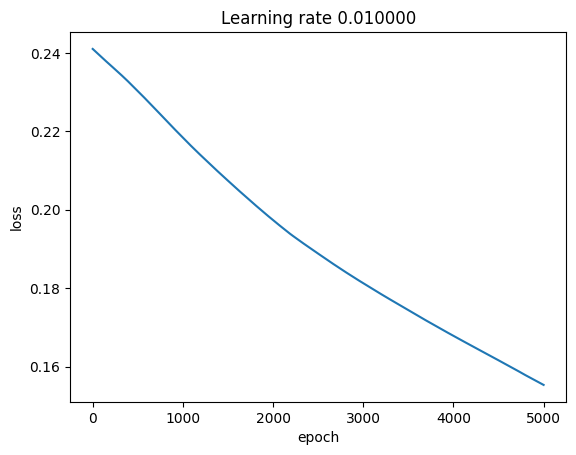

In [20]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f" % (learning_rate))
plt.show()